# ⚛️ H₂ VQE — Multi-Seed Noise Statistics (Production API)

This notebook studies how **noise** affects **H₂ VQE** using only the
**packaged VQE engine**. It focuses exclusively on **multi-seed statistics**:

- No manual QNodes
- No hand-built ansatz
- No single-seed demos

Instead, everything is driven by:

```python
from vqe.core import run_vqe_multi_seed_noise
```

---

## 🎯 What we compute

For the H₂ molecule using the **UCCSD** ansatz and **Adam** optimizer, we:

1. Sweep **depolarizing noise** strengths and compute:
   - Mean and standard deviation of the energy error (Delta E)
   - Mean and standard deviation of the fidelity vs a reference state
   - Across multiple random seeds
2. Repeat the same analysis for **amplitude damping** noise.

All Hamiltonian construction, ansatz building, devices, caching, and plotting
are handled inside the `vqe` package.

## 1️⃣ Imports and configuration

In [5]:
import numpy as np

from vqe.core import run_vqe_multi_seed_noise

## 2️⃣ Noise grid and seed selection

We now define:

- A set of **noise probabilities** between 0.0 and 0.10  
- A small set of **random seeds** for averaging  

These are reused for both depolarizing and amplitude-damping studies.

In [6]:
# Noise probabilities in [0.0, 0.10]
noise_levels = np.arange(0.0, 0.11, 0.02)
print("Noise levels:", noise_levels)

# Multiple seeds for statistics
seeds = np.arange(0, 5)
print("Seeds:", seeds)

# Optimizer settings
optimizer = "Adam"
steps = 50
stepsize = 0.2

Noise levels: [0.   0.02 0.04 0.06 0.08 0.1 ]
Seeds: [0 1 2 3 4]


## 3️⃣ Multi-seed depolarizing noise study

We first study **pure depolarizing noise**:

- `noise_type="depolarizing"`  
- Internally, amplitude damping is set to zero  
- The function:

  `run_vqe_multi_seed_noise(...)`

  will:
  - Run H₂ VQE across seeds and noise levels
  - Compute Delta E and fidelity statistics
  - Produce and save a plot via the shared plotting utilities

The plot is also displayed inline.


🔹 Computing noiseless reference runs...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s0_a56aed30983c.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s1_6f863ea3ee35.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s2_4926dff48095.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s3_b3f185f02013.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s4_882a5ac9f148.json
Reference mean energy = -1.137177 Ha

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s0_a56aed30983c.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s1_6f863ea3ee35.json

📂 Found cached result: /workspaces/Variational

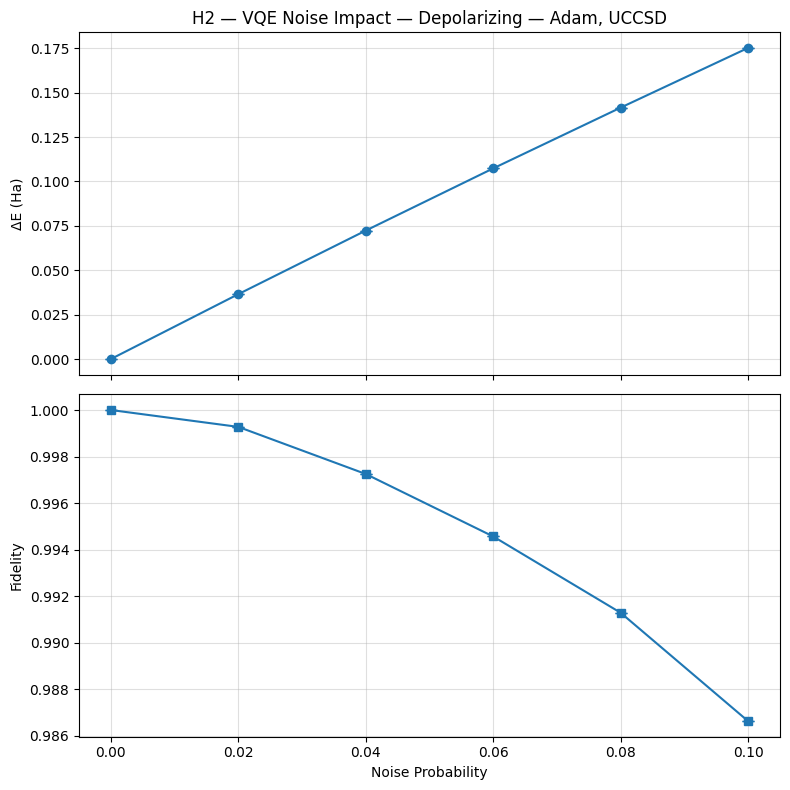

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/noise_stats_UCCSD_Adam_noise_scan_dep.png

✅ Multi-seed noise study complete for H2


In [7]:
_ = run_vqe_multi_seed_noise(
    molecule="H2",
    ansatz_name="UCCSD",
    optimizer_name=optimizer,
    steps=steps,
    stepsize=stepsize,
    seeds=seeds,
    noise_type="depolarizing",
    depolarizing_probs=noise_levels,
    mapping="jordan_wigner",
    force=False,
    show=True,
)

## 4️⃣ Multi-seed amplitude-damping noise study

Next we study **pure amplitude damping**:

- `noise_type="amplitude"`  
- Internally, depolarizing probabilities are set to zero  
- Again, `run_vqe_multi_seed_noise`:
  - Reuses caching where possible
  - Produces a Delta E vs noise and fidelity vs noise plot with error bars

We reuse the same `noise_levels` and `seeds` for consistency.


🔹 Computing noiseless reference runs...

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s0_a56aed30983c.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s1_6f863ea3ee35.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s2_4926dff48095.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s3_b3f185f02013.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s4_882a5ac9f148.json
Reference mean energy = -1.137177 Ha

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s0_a56aed30983c.json

📂 Found cached result: /workspaces/Variational_Quantum_Eigensolver/results/vqe/H2_uccsd_adam_noiseless_s1_6f863ea3ee35.json

📂 Found cached result: /workspaces/Variational

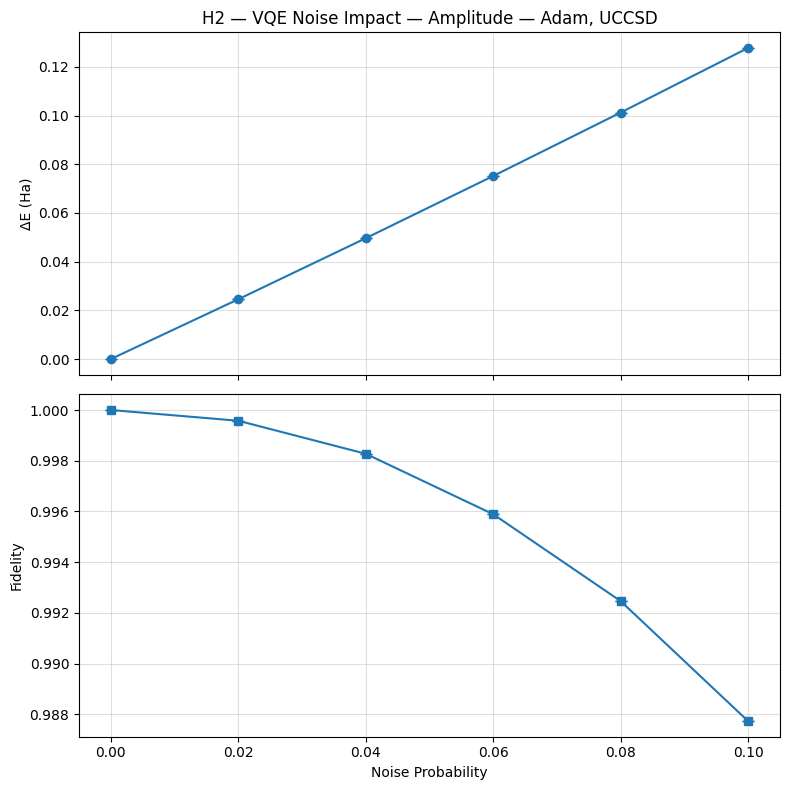

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H2/noise_stats_UCCSD_Adam_noise_scan_amp.png

✅ Multi-seed noise study complete for H2


In [8]:
_ = run_vqe_multi_seed_noise(
    molecule="H2",
    ansatz_name="UCCSD",
    optimizer_name=optimizer,
    steps=steps,
    stepsize=stepsize,
    seeds=seeds,
    noise_type="amplitude",
    depolarizing_probs=noise_levels,
    mapping="jordan_wigner",
    force=False,
    show=True,
)
